# NDVI using STAC
### Using NDVI, what is the average total area of “barren” (barren rock, sand, or snow) land for the Santa Cruz province of Argentina for the month of November, 2020.

https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html#

In [1]:
import json
import dask.distributed
import folium
import folium.plugins
import rasterio
import geopandas as gpd
import shapely.geometry
from shapely.geometry import mapping
from IPython.display import HTML, display
from pystac_client import Client
import dask
import rioxarray as rxr
import numpy as np
import earthpy.spatial as es
import earthpy.plot as ep
import matplotlib.pyplot as plt

from odc.stac import configure_rio, load
import stackstac

## Get polygon for Santa Cruz province

In [2]:
country = "Argentina"
province = "Santa Cruz"

<Axes: >

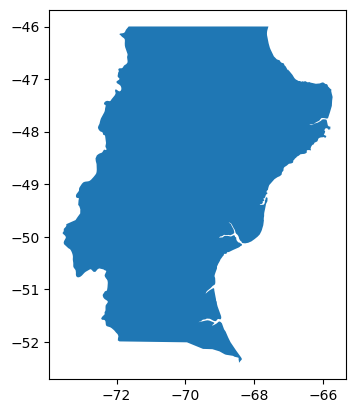

In [3]:
provinces = gpd.read_file("./data/states_provinces/ne_10m_admin_1_states_provinces.shp")
# Find Santa Cruz in the dataset
scdf = provinces.loc[(provinces['name'] == province) & (provinces['admin'] == country)]
scdf = scdf.reset_index(drop=True)
scdf.plot()

In [4]:
# Get the geojson polygon of the province
santa_cruz_dict = scdf.iloc[0].geometry.__geo_interface__

santa_cruz_polygon = json.dumps(santa_cruz_dict)

----

## Start Dask for parallel computing

In [5]:
client = dask.distributed.Client()
configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55153,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:55165,Total threads: 3
Dashboard: http://127.0.0.1:55169/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:55156,


----

## Get Data

Using Earth Search API with STAC: https://stacindex.org/catalogs/earth-search#/

Which collection should we use? Let's go with Sentinel 2, but there are two levels: 2A and 1C.

Level-1C product provides orthorectified Top-Of-Atmosphere (TOA) reflectance, with sub-pixel multispectral registration. Cloud and land/water masks are included in the product.

Level-2A product provides orthorectified atmospherically corrected Surface Reflactance, with sub-pixel multispectral registration. A Scene Classification map (cloud, cloud shadows, vegetation, soils/deserts, water, snow, etc.) is included in the product.

https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html#

### Get metadata

In [6]:
catalog = Client.open("https://earth-search.aws.element84.com/v1/")
catalog.title

'Earth Search by Element 84'

I'll search the Sentinel 2 Level 2A data for any images that intersect the polygon of the province and are from November 2020

In [7]:
query = catalog.search(collections=["sentinel-2-l2a"], datetime="2020-11-01/2020-12-01", intersects=santa_cruz_polygon)

items = list(query.items())
print(f"Found: {len(items):d} datasets")

# Convert STAC items into a GeoJSON FeatureCollection
stac_json = query.item_collection_as_dict()

Found: 787 datasets


In [8]:
gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")

In [9]:
gdf.columns

Index(['geometry', 'created', 'platform', 'constellation', 'instruments',
       'eo:cloud_cover', 'proj:epsg', 'mgrs:utm_zone', 'mgrs:latitude_band',
       'mgrs:grid_square', 'grid:code', 'view:sun_azimuth',
       'view:sun_elevation', 's2:degraded_msi_data_percentage',
       's2:nodata_pixel_percentage', 's2:saturated_defective_pixel_percentage',
       's2:dark_features_percentage', 's2:cloud_shadow_percentage',
       's2:vegetation_percentage', 's2:not_vegetated_percentage',
       's2:water_percentage', 's2:unclassified_percentage',
       's2:medium_proba_clouds_percentage', 's2:high_proba_clouds_percentage',
       's2:thin_cirrus_percentage', 's2:snow_ice_percentage',
       's2:product_type', 's2:processing_baseline', 's2:product_uri',
       's2:generation_time', 's2:datatake_id', 's2:datatake_type',
       's2:datastrip_id', 's2:granule_id', 's2:reflectance_conversion_factor',
       'datetime', 's2:sequence', 'earthsearch:s3_path',
       'earthsearch:payload_id', 'ear

In [10]:
# Compute granule id from components
gdf["granule"] = (
    gdf["mgrs:utm_zone"].apply(lambda x: f"{x:02d}")
    + gdf["mgrs:latitude_band"]
    + gdf["mgrs:grid_square"]
)

Let's limit to images with less than 20% cloud cover

In [11]:
cloud_free = gdf[gdf['eo:cloud_cover'] < 20]

In [12]:
def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

### Visualize items to ensure we have coverage

In [13]:
# https://github.com/python-visualization/folium/issues/1501
from branca.element import Figure

fig = Figure(width="700px", height="500px")
map1 = folium.Map()
fig.add_child(map1)

# folium.GeoJson(
#     style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
#     name="Query",
# ).add_to(map1)

cloud_free.explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "datetime",
        "eo:cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="STAC",
    m=map1,
)

map1.fit_bounds(bounds=convert_bounds(cloud_free.unary_union.bounds))
display(fig)

/Users/nick/anaconda3/envs/gis/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)


### Download actual data
We will use Dask to parallelize the data download and processing, so first we setup the process with proxies

In [14]:
cfg = {
    "sentinel-s2-l2a": {
        # "assets": {
        #     "*": {"data_type": "uint16", "nodata": 0},
        #     "SCL": {"data_type": "uint8", "nodata": 0},
        #     "visual": {"data_type": "uint8", "nodata": 0},
        # },
        "aliases": {"red": "B04", "green": "B03", "blue": "B02", "nir":"B08"},
    },
    "*": {"warnings": "ignore"},
}

In [15]:
# Since we will plot it on a map we need to use `EPSG:3857` projection
crs = "epsg:3857"

ds = load(
    items,
    bands=("red", "nir"),
    crs=crs,
    resolution=1000, # Because we are running this locally on a laptop, reducing the resolution to 1km x 1km
    chunks={},
    groupby="solar_day",
    stac_cfg=cfg,
)
display(ds)

<xarray.Dataset>
Dimensions:      (y: 1412, x: 1138, time: 25)
Coordinates:
  * y            (y) float64 -5.634e+06 -5.636e+06 ... -7.044e+06 -7.046e+06
  * x            (x) float64 -8.348e+06 -8.348e+06 ... -7.212e+06 -7.212e+06
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2020-11-01T14:45:34.941000 ... 2020-12...
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 1412, 1138), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 1412, 1138), meta=np.ndarray>

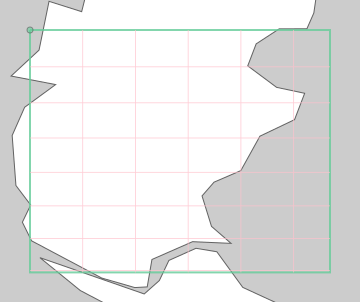

In [16]:
ds.odc.geobox

### Calculate NDVI

NDVI = (NIR - RED) / (NIR + RED), where
- RED is B4, 664.5 nm
- NIR is B8, 835.1 nm

In [17]:
ds["NDVI"] = (ds.nir - ds.red) / (ds.nir + ds.red)

### Compute

In [18]:
ds = ds.compute()

/Users/nick/anaconda3/envs/gis/lib/python3.11/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/Users/nick/anaconda3/envs/gis/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/nick/anaconda3/envs/gis/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/nick/anaconda3/envs/gis/lib/python3.11/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/nick/anaconda3/envs/gis/lib/python3.11/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/Users/nick/anaconda3/envs/gis/lib/p

In [19]:
ds

<xarray.Dataset>
Dimensions:      (y: 1412, x: 1138, time: 25)
Coordinates:
  * y            (y) float64 -5.634e+06 -5.636e+06 ... -7.044e+06 -7.046e+06
  * x            (x) float64 -8.348e+06 -8.348e+06 ... -7.212e+06 -7.212e+06
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2020-11-01T14:45:34.941000 ... 2020-12...
Data variables:
    red          (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    nir          (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    NDVI         (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan

(array([1.0063235e+07, 4.4057000e+04, 1.0322000e+04, 4.6560000e+03,
        5.0740000e+03, 1.4390000e+03, 1.6020000e+03, 1.9230000e+03,
        0.0000000e+00, 4.3970000e+03]),
 array([    0. ,  2184.5,  4369. ,  6553.5,  8738. , 10922.5, 13107. ,
        15291.5, 17476. , 19660.5, 21845. ]),
 <BarContainer object of 10 artists>)

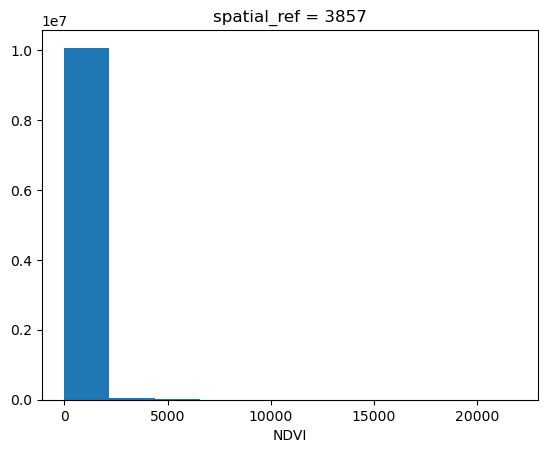

In [20]:
ds.NDVI.plot()

In [21]:
print("Max:",ds.NDVI.max())
print("Min:",ds.NDVI.min())
print("Mean:",ds.NDVI.mean())
print("Median:",ds.NDVI.median())

Max: <xarray.DataArray 'NDVI' ()>
array(21845.)
Coordinates:
    spatial_ref  int32 3857
Min: <xarray.DataArray 'NDVI' ()>
array(0.)
Coordinates:
    spatial_ref  int32 3857
Mean: <xarray.DataArray 'NDVI' ()>
array(74.55504022)
Coordinates:
    spatial_ref  int32 3857
Median: <xarray.DataArray 'NDVI' ()>
array(0.14399093)
Coordinates:
    spatial_ref  int32 3857


#### Clearly there are some outliers, as there should be no values > 1. Judging by the histogram, there are not many outliers, so we will just drop the ones above 1

In [22]:
ds = ds.where(ds['NDVI'] < 1.0)

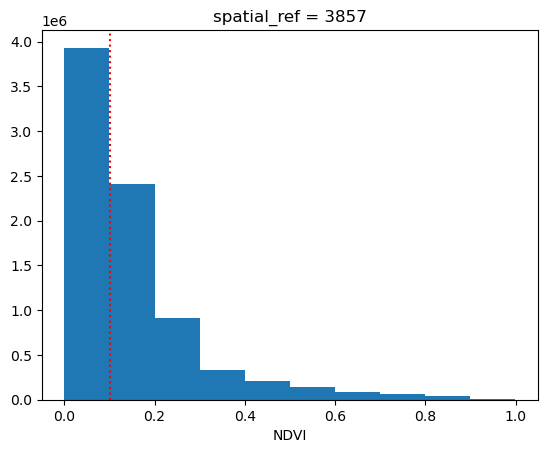

In [23]:
ds.NDVI.plot()
plt.axvline(x=0.1, color='red', linestyle='dotted')

In [24]:
# Collapse the time dimension by taking the mean value for each pixel over the month
ds = ds.mean(dim='time')
ds

<xarray.Dataset>
Dimensions:      (y: 1412, x: 1138)
Coordinates:
  * y            (y) float64 -5.634e+06 -5.636e+06 ... -7.044e+06 -7.046e+06
  * x            (x) float64 -8.348e+06 -8.348e+06 ... -7.212e+06 -7.212e+06
    spatial_ref  int32 3857
Data variables:
    red          (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    nir          (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    NDVI         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

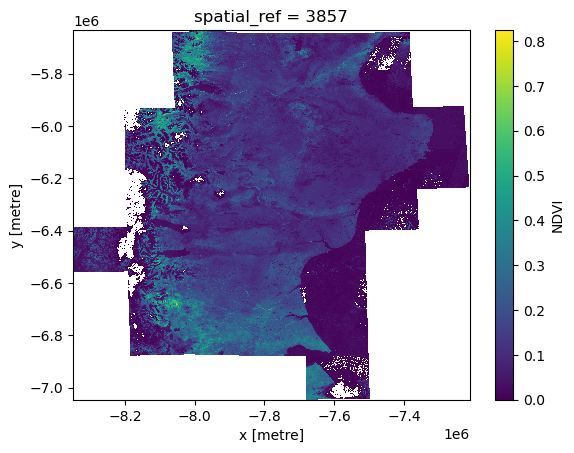

In [25]:
ndvi = ds.NDVI
ndvi.plot()

In [26]:
ndvi_clip = ndvi.rio.clip(scdf.geometry.apply(mapping), scdf.crs, drop=False, invert=False)

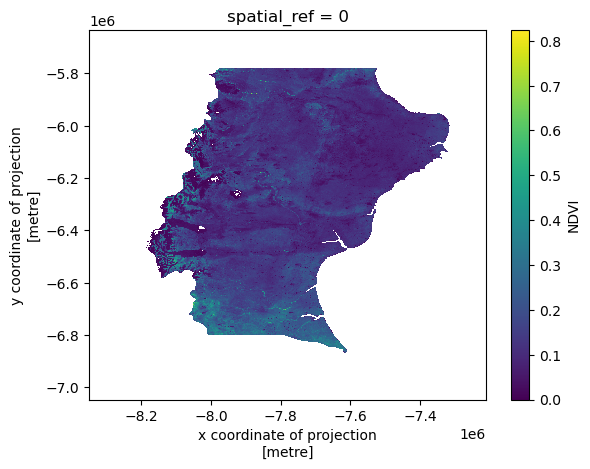

In [27]:
ndvi_clip.plot()

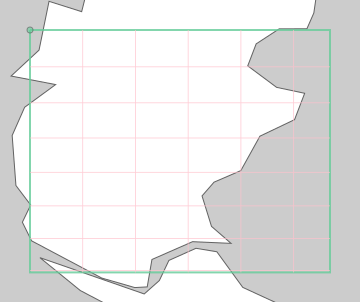

In [28]:
ndvi_clip.odc.geobox

## Calculate / Map Results

In [29]:
ndvi_class_bins = [-1, 0.1, 0.5, 1, np.nan]
ndvi_density_class = np.digitize(ndvi_clip, ndvi_class_bins)

# Apply the nodata mask to the newly classified NDVI data
ndvi_density_class = np.ma.masked_where(
    np.ma.getmask(ndvi), ndvi_density_class
)
np.unique(ndvi_density_class)

masked_array(data=[1, 2, 3, 5],
             mask=False,
       fill_value=999999)

In [30]:
from matplotlib.colors import ListedColormap
# Define color map
nbr_colors = ["grey", "y", "g", "white"]
nbr_cmap = ListedColormap(nbr_colors)

# Define class names
ndvi_cat_names = [
    "Barren (Rock, Sand, Snow)",
    "Sparse Vegetation (Shrubs, Grasslands)",
    "Dense Vegetation (Forest)",
    "No Data"
]

# Get list of classes
classes = np.unique(ndvi_density_class)
classes = classes.tolist()

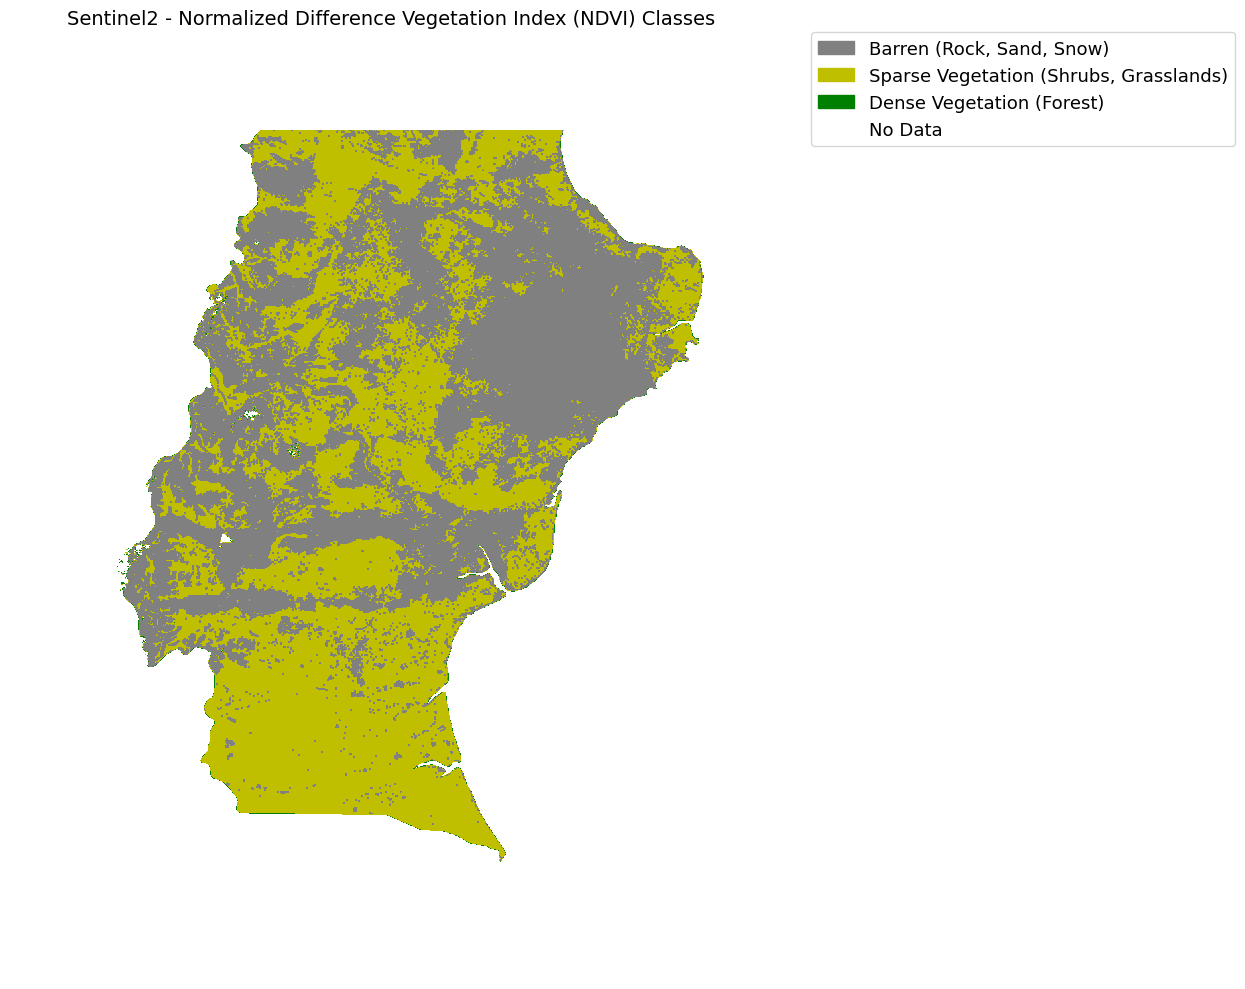

In [31]:
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot()
im1 = ax.imshow(np.squeeze(ndvi_density_class), cmap=nbr_cmap)
ep.draw_legend(im_ax=im1, classes=classes, titles=ndvi_cat_names)
ax.set_title(
    "Sentinel2 - Normalized Difference Vegetation Index (NDVI) Classes",
    fontsize=14,
)
ax.set_axis_off()
plt.tight_layout()

## Calculate barren area

"NDVI values range from +1.0 to -1.0. Areas of barren rock, sand, or snow usually show very low NDVI values (for example, 0.1 or less). Sparse vegetation such as shrubs and grasslands or senescing crops may result in moderate NDVI values (approximately 0.2 to 0.5). High NDVI values (approximately 0.6 to 0.9) correspond to dense vegetation such as that found in temperate and tropical forests or crops at their peak growth stage"

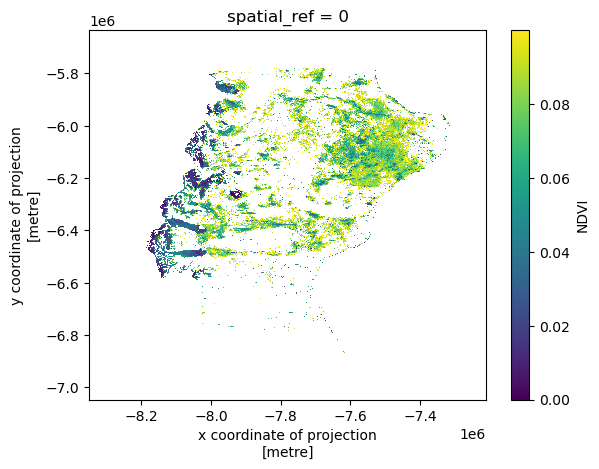

In [32]:
barren = ndvi_clip.where(ndvi_clip <= 0.1)
barren.plot()

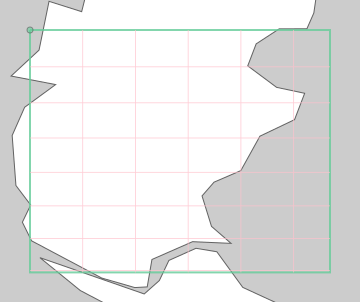

In [33]:
barren.odc.geobox

In [34]:
barren.notnull().sum()

<xarray.DataArray 'NDVI' ()>
array(181272)
Coordinates:
    spatial_ref  int64 0

## Santa Cruz, Argentina has 181,272 km2 of barren (NDVI <= 0.1) land

Refrences:\
https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-e84-aws.html#\
https://www.streambatch.io/knowledge/ndvi-from-sentinel-2-imagery-using-stac\
https://stacindex.org/catalogs/earth-search#/43bjKKcJQfxYaT1ir3Ep6uENfjEoQrjkzhd2?t=3\
https://www.coiled.io/\